## Import TensorFlow and other libraries

In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
import tensorflow as tf


import time

from matplotlib import pyplot as plt
from IPython import display
import numpy as np
import os
import sys
import cv2
from sklearn.model_selection import train_test_split
import tkinter
from tkinter import filedialog
tkinter.Tk().withdraw()
path=filedialog.askdirectory(title='path for whole dataset')
date="27Apr"
mask="Dataset3_low_GN"
csv_path=3
from glob import glob
#os.environ["CUDA_VISIBLE_DEVICES"]="2"
#tf_device='/gpu:0'

2022-07-20 18:13:15.936798: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
tf.config.list_physical_devices('GPU')

2022-07-20 18:13:31.421627: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2022-07-20 18:13:31.443568: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:0d:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.45GiB deviceMemoryBandwidth: 625.94GiB/s
2022-07-20 18:13:31.443593: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-07-20 18:13:31.444320: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-07-20 18:13:31.444342: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-07-20 18:13:31.445197: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2022-07-20 18:13:31.445381: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcurand.so

In [3]:
#mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:2", "/gpu:3"])

In [4]:
BUFFER_SIZE = 400
BATCH_SIZE = 150 #25 20
IMAGE_SIZE=256

In [5]:
def load_data(path, split=0.02):
    images = sorted(glob(os.path.join(path, "Images/*")))
    masks = sorted(glob(os.path.join(path, "Masks/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [6]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y)=load_data(path)

In [7]:
len(train_y)

9086

In [8]:
def load_train(a,b=0,condtn=True):
    image1 = tf.io.read_file(a)
    input_image = tf.image.decode_png(image1)
    input_image=tf.image.resize(input_image, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image=tf.cast(input_image,tf.float32)
    
    
    
    if(condtn==True):
        image2 = tf.io.read_file(b)
        real_image = tf.image.decode_png(image2)
    
        real_image=tf.image.resize(real_image, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
        real_image=tf.cast(real_image,tf.float32)
        input_image,real_image=augment(input_image,real_image)
        real_image = (real_image / 127.5) - 1
        input_image = (input_image / 127.5) - 1
        return input_image, real_image
    else:
        input_image = (input_image / 127.5) - 1
        return input_image

In [9]:
def load_test(a,b=0,condtn=True):
    image1 = tf.io.read_file(a)
    input_image = tf.image.decode_png(image1)
    input_image=tf.image.resize(input_image, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image=tf.cast(input_image,tf.float32)
    
    input_image = (input_image / 127.5) - 1
    
    if(condtn==True):
        image2 = tf.io.read_file(b)
        real_image = tf.image.decode_png(image2)
    
        real_image=tf.image.resize(real_image, [256, 256],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
        real_image=tf.cast(real_image,tf.float32)
    
        real_image = (real_image / 127.5) - 1

        return input_image, real_image
    else:
        return input_image

In [10]:
len(test_y)

189

In [11]:
def augment(input_image,real_image):
    seed=(1,2)
    tf.random.set_seed(1234)
    if tf.random.uniform(()) > 0.5:
        input_image=tf.image.stateless_random_brightness(input_image,max_delta=1.5,seed=seed)
        #input_image=tf.image.stateless_random_hue(input_image,max_delta=0.5,seed=seed)
        input_image=tf.image.stateless_random_saturation(input_image, lower=0, upper=1.5,seed=seed)

        #real_image=tf.image.random_brightness(real_image,max_delta=0.1)
        input_image = tf.image.stateless_random_contrast(input_image, lower=0, upper=1.5,seed=seed)
        #real_image = tf.image.stateless_random_contrast(real_image, lower=0.1, upper=0.9,seed=seed)
        x=tf.image.stateless_random_crop(input_image, size=(224,224,3), seed=seed)
        y=tf.image.stateless_random_crop(real_image, size=(224,224,3), seed=seed)
        real_image=tf.image.resize(y, [256, 256],
                         method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        input_image=tf.image.resize(x, [256, 256],
                         method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        
        input_image=tf.clip_by_value(input_image, 0, 255)
        real_image=tf.clip_by_value(real_image, 0, 255)
        input_image=tf.image.stateless_random_flip_left_right(input_image, seed=seed)
        real_image=tf.image.stateless_random_flip_up_down(real_image, seed=seed)
    return input_image,real_image

In [12]:
train_dataset=tf.data.Dataset.from_tensor_slices((train_x,train_y))
train_dataset=train_dataset.shuffle(BUFFER_SIZE)
train_dataset=train_dataset.map(load_train)
#train_dataset=train_dataset.map(augment)
train_dataset=train_dataset.batch(BATCH_SIZE)
valid_dataset=tf.data.Dataset.from_tensor_slices((valid_x,valid_y))
valid_dataset=valid_dataset.map(load_test)
valid_dataset=valid_dataset.batch(1)
test_dataset=tf.data.Dataset.from_tensor_slices((test_x,test_y))
test_dataset=test_dataset.map(load_test)
test_dataset=test_dataset.batch(1)

2022-07-20 18:13:36.200759: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-20 18:13:36.223704: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3700015000 Hz
2022-07-20 18:13:36.224557: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x564c6e178bd0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-07-20 18:13:36.224579: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-07-20 18:13:36.224920: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:0d:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77G

In [13]:
inp,re=load_train(train_x[10],train_y[10])

2022-07-20 18:13:37.471330: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


tf.Tensor(0.70980394, shape=(), dtype=float32)
tf.Tensor(-0.7411765, shape=(), dtype=float32)
tf.Tensor(0.18431377, shape=(), dtype=float32)
tf.Tensor(-0.8745098, shape=(), dtype=float32)
tf.Tensor(0.7347009, shape=(), dtype=float32)
tf.Tensor(-0.52117896, shape=(), dtype=float32)
tf.Tensor(-0.15294117, shape=(), dtype=float32)
tf.Tensor(-0.58431375, shape=(), dtype=float32)
tf.Tensor(0.6862745, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(0.3176471, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(0.8214563, shape=(), dtype=float32)
tf.Tensor(-1.0, shape=(), dtype=float32)
tf.Tensor(0.5058824, shape=(), dtype=float32)
tf.Tensor(-0.8745098, shape=(), dtype=float32)


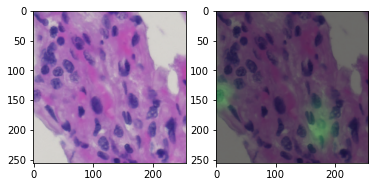

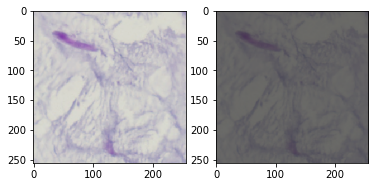

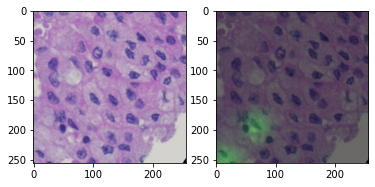

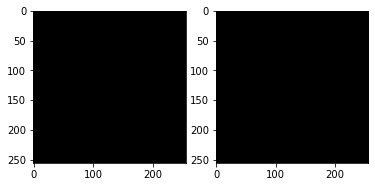

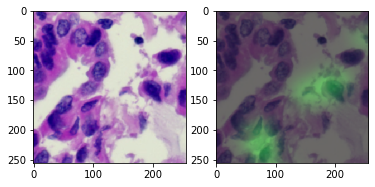

In [14]:
for x,y in train_dataset.take(1):
    #
    # print(x.shape[0])
    for i in range(5):
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(x[i]*0.5+0.5)
        print(tf.reduce_max(x[i]))
        print(tf.reduce_min(x[i]))
        plt.subplot(1,2,2)
        plt.imshow(y[i]*0.5+0.5)
        print(tf.reduce_max(y[i]))
        print(tf.reduce_min(y[i]))

## Build the Generator
  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).


In [15]:
OUTPUT_CHANNELS = 3

In [16]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [18]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

2022-07-20 18:10:12.438074: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-07-20 18:10:12.820174: E tensorflow/stream_executor/cuda/cuda_dnn.cc:336] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2022-07-20 18:10:12.823454: E tensorflow/stream_executor/cuda/cuda_dnn.cc:336] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above. [Op:Conv2D]

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

In [ ]:
def Generator():
  size=4
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, size, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128,size), # (bs, 64, 64, 128)
    downsample(256, size), # (bs, 32, 32, 256)
    downsample(512, size), # (bs, 16, 16, 512)
    downsample(512, size), # (bs, 8, 8, 512)
    downsample(512, size), # (bs, 4, 4, 512)
    downsample(512, size), # (bs, 2, 2, 512)
    downsample(512, size), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, size, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, size, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, size, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, size), # (bs, 16, 16, 1024)
    upsample(256, size), # (bs, 32, 32, 512)
    upsample(128, size), # (bs, 64, 64, 256)
    upsample(64, size), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, size,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [ ]:
gen_output = generator(inp[tf.newaxis,...],training=False)
plt.imshow(gen_output[0,...]*0.5+0.5)

* **Generator loss**
  * It is a sigmoid cross entropy loss of the generated images and an **array of ones**.
  * The [paper](https://arxiv.org/abs/1611.07004) also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
  * This allows the generated image to become structurally similar to the target image.
  * The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the [paper](https://arxiv.org/abs/1611.07004).

The training procedure for the generator is shown below:

In [ ]:
LAMBDA = 100

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  #LAMBDA=dynamic_lambda(target,gen_output)

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## Build the Discriminator
  * The Discriminator is a PatchGAN.
  * Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
  * The shape of the output after the last layer is (batch_size, 30, 30, 1)
  * Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
  * Discriminator receives 2 inputs.
    * Input image and the target image, which it should classify as real.
    * Input image and the generated image (output of generator), which it should classify as fake.
    * We concatenate these 2 inputs together in the code (`tf.concat([inp, tar], axis=-1)`)

In [ ]:
def Discriminator():
  size=4
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  inp2 = tf.keras.layers.GaussianNoise(stddev=0.2)(inp)
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')
  tar2= tf.keras.layers.GaussianNoise(stddev=0.2)(tar)
  x = tf.keras.layers.concatenate([inp2, tar2]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, size, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, size)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, size)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, size, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, size, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [ ]:
discriminator.summary()

In [ ]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

**Discriminator loss**
  * The discriminator loss function takes 2 inputs; **real images, generated images**
  * real_loss is a sigmoid cross entropy loss of the **real images** and an **array of ones(since these are the real images)**
  * generated_loss is a sigmoid cross entropy loss of the **generated images** and an **array of zeros(since these are the fake images)**
  * Then the total_loss is the sum of real_loss and the generated_loss


In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
#1-bce-dice

def loss_object_1(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.sigmoid(y_pred)
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    l=loss_object1(y_true,y_pred)
    return tf.abs(-l+(numerator / denominator))

In [ ]:
def dynamic_lambda(i1,i2):
  
    a=tf.equal(i1,i2)
    b=tf.cast(a,tf.float32)
    
    L=LAMBDA/(0.1+tf.reduce_mean(b))
    tf.print(L, output_stream=sys.stderr)
    return L

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss
    #print(total_disc_loss)
    return total_disc_loss

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer the [paper](https://arxiv.org/abs/1611.07004).

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## Define the Optimizers and Checkpoint-saver


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-3, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-2, beta_1=0.5)


In [ ]:
checkpoint_dir = './training_checkpoints/'+date+"/"+mask
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [ ]:
#checkpoint.save(file_prefix = checkpoint_prefix)

## Generate Images

Write a function to plot some images during training.

* We pass images from the test dataset to the generator.
* The generator will then translate the input image into the output.
* Last step is to plot the predictions and **voila!**

Note: The `training=True` is intentional here since
we want the batch statistics while running the model
on the test dataset. If we use training=False, we will get
the accumulated statistics learned from the training dataset
(which we don't want)

In [ ]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ref for style_transfer', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [ ]:
for example_input, example_target in test_dataset.take(5):
    #print("*")
    generate_images(generator, example_input, example_target)

## Training

* For each example input generate an output.
* The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
* Next, we calculate the generator and the discriminator loss.
* Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
* Then log the losses to TensorBoard.

In [ ]:
EPOCHS = 150

In [ ]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/"+date+" "+mask+" " + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
disc_loss_1=[]
gen_total_loss_1=[]
gen_l1_loss_1=[]
gen_gan_loss_1=[]
psnr=[]
ssim=[]

In [ ]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)
    
    ps=tf.reduce_mean(tf.image.psnr(gen_output,target, max_val=1.0))
    #tf.print(ps)
    #psnr.append(ps)
    ss=tf.reduce_mean(tf.image.ssim(gen_output,target, 1.0))
    #ssim.append(ss)
    #tf.print(ss)
    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
  
  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)
    
    #print("gen_l1_loss")
    #tf.print(gen_l1_loss, output_stream=sys.stderr)
    #print("gen_gan_loss")
    #tf.print(ss, output_stream=sys.stderr)
    #tf.print(gen_gan_loss, output_stream=sys.stderr)
    #print("disc_loss")
    #tf.print(disc_loss, output_stream=sys.stderr)
    return gen_total_loss, gen_gan_loss, gen_l1_loss,disc_loss,ps,ss

The actual training loop:

* Iterates over the number of epochs.
* On each epoch it clears the display, and runs `generate_images` to show it's progress.
* On each epoch it iterates over the training dataset, printing a '.' for each example.
* It saves a checkpoint every 20 epochs.

In [ ]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()

        display.clear_output(wait=True)

        for example_input, example_target in test_ds.take(3):
            generate_images(generator, example_input, example_target)
        
        print("Epoch: ", epoch)

    # Train
        for n, (input_image, target) in train_ds.enumerate():
            print('.', end='')
   
            train_step(input_image, target, epoch)

    # saving (checkpoint) the model every 5 epochs
        if (epoch + 1) % 5 == 0:
        
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
    #checkpoint.save(file_prefix = checkpoint_prefix)

In [ ]:
checkpoint_dir

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
for example_input, example_target in valid_dataset.take(3):
            generate_images(generator, example_input, example_target)

This training loop saves logs you can easily view in TensorBoard to monitor the training progress. Working locally you would launch a separate tensorboard process. In a notebook, if you want to monitor with TensorBoard it's easiest to launch the viewer before starting the training.

To launch the viewer paste the following into a code-cell:

In [ ]:
#docs_infra: no_execute
#!kill 1787
%load_ext tensorboard
%tensorboard --logdir {log_dir}  
#%reload_ext tensorboard

Now run the training loop:

In [ ]:
fit(train_dataset, EPOCHS, valid_dataset)

Interpreting the logs from a GAN is more subtle than a simple classification or regression model. Things to look for::

* Check that neither model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
* The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2: That the discriminator is on average equally uncertain about the two options.
* For the `disc_loss` a value below `0.69` means the discriminator is doing better than random, on the combined set of real+generated images.
* For the `gen_gan_loss` a value below `0.69` means the generator i doing better than random at foolding the descriminator.
* As training progresses the `gen_l1_loss` should go down.

## Restore the latest checkpoint and test

In [55]:
!ls {checkpoint_dir}

checkpoint		     ckpt-25.index
ckpt-10.data-00000-of-00001  ckpt-26.data-00000-of-00001
ckpt-10.index		     ckpt-26.index
ckpt-11.data-00000-of-00001  ckpt-27.data-00000-of-00001
ckpt-11.index		     ckpt-27.index
ckpt-12.data-00000-of-00001  ckpt-28.data-00000-of-00001
ckpt-12.index		     ckpt-28.index
ckpt-13.data-00000-of-00001  ckpt-29.data-00000-of-00001
ckpt-13.index		     ckpt-29.index
ckpt-14.data-00000-of-00001  ckpt-2.data-00000-of-00001
ckpt-14.index		     ckpt-2.index
ckpt-15.data-00000-of-00001  ckpt-30.data-00000-of-00001
ckpt-15.index		     ckpt-30.index
ckpt-16.data-00000-of-00001  ckpt-31.data-00000-of-00001
ckpt-16.index		     ckpt-31.index
ckpt-17.data-00000-of-00001  ckpt-32.data-00000-of-00001
ckpt-17.index		     ckpt-32.index
ckpt-18.data-00000-of-00001  ckpt-33.data-00000-of-00001
ckpt-18.index		     ckpt-33.index
ckpt-19.data-00000-of-00001  ckpt-3.data-00000-of-00001
ckpt-19.index		     ckpt-3.index
ckpt-1.data-00000-of-00001   ckpt-4.data-00000-of-00001
ckpt-1.

## Generate using test dataset

# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset:
    for a,b in zip(inp[:2],tar[:2]):
        a=np.expand_dims(a,axis=0)
        b=np.expand_dims(b,axis=0)
        generate_images(generator, a, b)

In [42]:
#!pip install pandas
import pandas as pd



In [43]:
images = sorted(glob(os.path.join(path, "images/*")))
masks = sorted(glob(os.path.join(path, "masks/*")))


In [45]:
green = np.zeros([256,256,3],dtype=np.float32)
green[:]=(0,225,0)
green=green/127.5-1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705


5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344


6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992


8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642


10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
1024

11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
1161

12823
12824
12825
12826
12827
12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
12958
12959
12960
12961
12962
12963
12964
12965
12966
12967
12968
12969
12970
12971
12972
12973
12974
12975
12976
12977
12978
12979
12980
12981
12982
12983
12984
12985
12986
12987
12988
1298

14196
14197
14198
14199
14200
14201
14202
14203
14204
14205
14206
14207
14208
14209
14210
14211
14212
14213
14214
14215
14216
14217
14218
14219
14220
14221
14222
14223
14224
14225
14226
14227
14228
14229
14230
14231
14232
14233
14234
14235
14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
14336
14337
14338
14339
14340
14341
14342
14343
14344
14345
14346
14347
14348
14349
14350
14351
14352
14353
14354
14355
14356
14357
14358
14359
14360
14361
1436

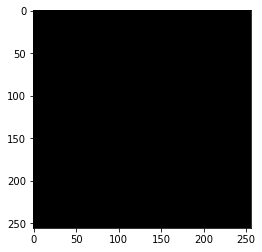

In [46]:
ind_ssim=[]
numbers=[]
for i in range(len(images)):
    print(i)
    a,b=load(images[i],masks[i])
    v=generator(np.expand_dims(a,axis=0))
    ss=tf.reduce_mean(tf.image.ssim(v,np.expand_dims(b,axis=0), 1.0))
    #gre=tf.reduce_mean(tf.math.sqrt(tf.abs(tf.math.square(green)-tf.math.square(v[0]))))
    img=v[0]*0.5+0.5
    plt.imshow(img.numpy())
    #tf.print(gre)
    
    ind_ssim.append((ss.numpy(),i))

    #img=np.asarray(v[0]*0.5+0.5,np.uint8)

In [47]:
ind_ssim.sort()

In [48]:
max(ind_ssim)

(1.0, 14871)

In [49]:
ssim3=[]
for x in ind_ssim:
    ssim3.append(x[1])

In [50]:

df_ssim_3=pd.DataFrame({"old_numbers":ssim3})

In [51]:
df_ssim_3

,old_numbers
0,5013
1,744
2,5025
3,4988
4,2935
...,...
14867,14860
14868,14861
14869,14869
14870,14870


In [52]:
df_ssim_3.to_csv(os.getcwd()+"/old_nos_new_test"+date+".csv")

In [53]:

df_ssim_3=pd.read_csv(os.getcwd()+"/old_nos_new_test"+date+".csv")
path_to_store=os.getcwd()+"/ans_cd3_new/"+date+"/"+mask+"/"
p1=os.path.join(path_to_store,"sorted")
p2=os.path.join(path_to_store,"unsorted")
p3=os.path.join(path_to_store,"sorted_gt")
p4=os.path.join(path_to_store,"unsorted_gt")
os.makedirs(p1,exist_ok=True)
os.makedirs(p2,exist_ok=True)
os.makedirs(p3,exist_ok=True)
os.makedirs(p4,exist_ok=True)

In [54]:
ssim3=df_ssim_3["old_numbers"].tolist()

In [55]:
ssim3

[5013,
 744,
 5025,
 4988,
 2935,
 5661,
 5028,
 5001,
 4990,
 3838,
 11422,
 720,
 5667,
 4977,
 5050,
 5010,
 1712,
 12966,
 3836,
 5009,
 14077,
 5659,
 3948,
 2616,
 4500,
 7855,
 14190,
 4514,
 4529,
 2922,
 4917,
 4125,
 5713,
 7104,
 14667,
 4984,
 5041,
 5664,
 5703,
 5680,
 5635,
 5716,
 6022,
 794,
 5633,
 5019,
 764,
 10950,
 5678,
 732,
 5306,
 5625,
 14165,
 1985,
 5683,
 5700,
 11434,
 2906,
 4985,
 4948,
 3985,
 3942,
 9772,
 2948,
 1722,
 4979,
 4974,
 5699,
 5725,
 4168,
 4972,
 1938,
 2879,
 4138,
 5686,
 5654,
 4968,
 4976,
 5723,
 6765,
 4963,
 10038,
 5647,
 2934,
 4244,
 11370,
 3595,
 11421,
 9738,
 9484,
 2902,
 5627,
 5639,
 5023,
 12705,
 13141,
 4935,
 749,
 4981,
 783,
 10866,
 9727,
 5620,
 2133,
 1406,
 14578,
 5582,
 6047,
 776,
 13159,
 4521,
 5048,
 1707,
 5608,
 736,
 5671,
 14668,
 796,
 1297,
 14553,
 5631,
 5717,
 735,
 2166,
 13657,
 809,
 9740,
 3111,
 734,
 2996,
 5632,
 7346,
 5210,
 13574,
 14152,
 4490,
 14088,
 5714,
 14357,
 10675,
 5617,
 7

In [56]:
x=0
for i in (ssim3):
    a,b=load(images[i],masks[i])
    v=generator(np.expand_dims(a,axis=0))
    img=v[0]*0.5+0.5
    img2=b*0.5+0.5
    #plt.figure()
    #plt.imshow(img.numpy())
    #img=np.asarray(v[0]*0.5+0.5,np.uint8)
    
    plt.imsave(p1+"/"+f"{x:06d}"+".png",img.numpy())
    plt.imsave(p2+"/"+f"{i:06d}"+".png",img.numpy())
    plt.imsave(p3+"/"+f"{x:06d}"+".png",img2.numpy())
    plt.imsave(p4+"/"+f"{i:06d}"+".png",img2.numpy())
    #plt.imsave(os.getcwd()+"/inp/"+str(x)+".png",img2.numpy())
    print(x,end=" ")
    x=x+1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

1862 1863 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875 1876 1877 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 

3501 3502 3503 3504 3505 3506 3507 3508 3509 3510 3511 3512 3513 3514 3515 3516 3517 3518 3519 3520 3521 3522 3523 3524 3525 3526 3527 3528 3529 3530 3531 3532 3533 3534 3535 3536 3537 3538 3539 3540 3541 3542 3543 3544 3545 3546 3547 3548 3549 3550 3551 3552 3553 3554 3555 3556 3557 3558 3559 3560 3561 3562 3563 3564 3565 3566 3567 3568 3569 3570 3571 3572 3573 3574 3575 3576 3577 3578 3579 3580 3581 3582 3583 3584 3585 3586 3587 3588 3589 3590 3591 3592 3593 3594 3595 3596 3597 3598 3599 3600 3601 3602 3603 3604 3605 3606 3607 3608 3609 3610 3611 3612 3613 3614 3615 3616 3617 3618 3619 3620 3621 3622 3623 3624 3625 3626 3627 3628 3629 3630 3631 3632 3633 3634 3635 3636 3637 3638 3639 3640 3641 3642 3643 3644 3645 3646 3647 3648 3649 3650 3651 3652 3653 3654 3655 3656 3657 3658 3659 3660 3661 3662 3663 3664 3665 3666 3667 3668 3669 3670 3671 3672 3673 3674 3675 3676 3677 3678 3679 3680 3681 3682 3683 3684 3685 3686 3687 3688 3689 3690 3691 3692 3693 3694 3695 3696 3697 3698 3699 3700 

5140 5141 5142 5143 5144 5145 5146 5147 5148 5149 5150 5151 5152 5153 5154 5155 5156 5157 5158 5159 5160 5161 5162 5163 5164 5165 5166 5167 5168 5169 5170 5171 5172 5173 5174 5175 5176 5177 5178 5179 5180 5181 5182 5183 5184 5185 5186 5187 5188 5189 5190 5191 5192 5193 5194 5195 5196 5197 5198 5199 5200 5201 5202 5203 5204 5205 5206 5207 5208 5209 5210 5211 5212 5213 5214 5215 5216 5217 5218 5219 5220 5221 5222 5223 5224 5225 5226 5227 5228 5229 5230 5231 5232 5233 5234 5235 5236 5237 5238 5239 5240 5241 5242 5243 5244 5245 5246 5247 5248 5249 5250 5251 5252 5253 5254 5255 5256 5257 5258 5259 5260 5261 5262 5263 5264 5265 5266 5267 5268 5269 5270 5271 5272 5273 5274 5275 5276 5277 5278 5279 5280 5281 5282 5283 5284 5285 5286 5287 5288 5289 5290 5291 5292 5293 5294 5295 5296 5297 5298 5299 5300 5301 5302 5303 5304 5305 5306 5307 5308 5309 5310 5311 5312 5313 5314 5315 5316 5317 5318 5319 5320 5321 5322 5323 5324 5325 5326 5327 5328 5329 5330 5331 5332 5333 5334 5335 5336 5337 5338 5339 

6780 6781 6782 6783 6784 6785 6786 6787 6788 6789 6790 6791 6792 6793 6794 6795 6796 6797 6798 6799 6800 6801 6802 6803 6804 6805 6806 6807 6808 6809 6810 6811 6812 6813 6814 6815 6816 6817 6818 6819 6820 6821 6822 6823 6824 6825 6826 6827 6828 6829 6830 6831 6832 6833 6834 6835 6836 6837 6838 6839 6840 6841 6842 6843 6844 6845 6846 6847 6848 6849 6850 6851 6852 6853 6854 6855 6856 6857 6858 6859 6860 6861 6862 6863 6864 6865 6866 6867 6868 6869 6870 6871 6872 6873 6874 6875 6876 6877 6878 6879 6880 6881 6882 6883 6884 6885 6886 6887 6888 6889 6890 6891 6892 6893 6894 6895 6896 6897 6898 6899 6900 6901 6902 6903 6904 6905 6906 6907 6908 6909 6910 6911 6912 6913 6914 6915 6916 6917 6918 6919 6920 6921 6922 6923 6924 6925 6926 6927 6928 6929 6930 6931 6932 6933 6934 6935 6936 6937 6938 6939 6940 6941 6942 6943 6944 6945 6946 6947 6948 6949 6950 6951 6952 6953 6954 6955 6956 6957 6958 6959 6960 6961 6962 6963 6964 6965 6966 6967 6968 6969 6970 6971 6972 6973 6974 6975 6976 6977 6978 6979 

8420 8421 8422 8423 8424 8425 8426 8427 8428 8429 8430 8431 8432 8433 8434 8435 8436 8437 8438 8439 8440 8441 8442 8443 8444 8445 8446 8447 8448 8449 8450 8451 8452 8453 8454 8455 8456 8457 8458 8459 8460 8461 8462 8463 8464 8465 8466 8467 8468 8469 8470 8471 8472 8473 8474 8475 8476 8477 8478 8479 8480 8481 8482 8483 8484 8485 8486 8487 8488 8489 8490 8491 8492 8493 8494 8495 8496 8497 8498 8499 8500 8501 8502 8503 8504 8505 8506 8507 8508 8509 8510 8511 8512 8513 8514 8515 8516 8517 8518 8519 8520 8521 8522 8523 8524 8525 8526 8527 8528 8529 8530 8531 8532 8533 8534 8535 8536 8537 8538 8539 8540 8541 8542 8543 8544 8545 8546 8547 8548 8549 8550 8551 8552 8553 8554 8555 8556 8557 8558 8559 8560 8561 8562 8563 8564 8565 8566 8567 8568 8569 8570 8571 8572 8573 8574 8575 8576 8577 8578 8579 8580 8581 8582 8583 8584 8585 8586 8587 8588 8589 8590 8591 8592 8593 8594 8595 8596 8597 8598 8599 8600 8601 8602 8603 8604 8605 8606 8607 8608 8609 8610 8611 8612 8613 8614 8615 8616 8617 8618 8619 

10049 10050 10051 10052 10053 10054 10055 10056 10057 10058 10059 10060 10061 10062 10063 10064 10065 10066 10067 10068 10069 10070 10071 10072 10073 10074 10075 10076 10077 10078 10079 10080 10081 10082 10083 10084 10085 10086 10087 10088 10089 10090 10091 10092 10093 10094 10095 10096 10097 10098 10099 10100 10101 10102 10103 10104 10105 10106 10107 10108 10109 10110 10111 10112 10113 10114 10115 10116 10117 10118 10119 10120 10121 10122 10123 10124 10125 10126 10127 10128 10129 10130 10131 10132 10133 10134 10135 10136 10137 10138 10139 10140 10141 10142 10143 10144 10145 10146 10147 10148 10149 10150 10151 10152 10153 10154 10155 10156 10157 10158 10159 10160 10161 10162 10163 10164 10165 10166 10167 10168 10169 10170 10171 10172 10173 10174 10175 10176 10177 10178 10179 10180 10181 10182 10183 10184 10185 10186 10187 10188 10189 10190 10191 10192 10193 10194 10195 10196 10197 10198 10199 10200 10201 10202 10203 10204 10205 10206 10207 10208 10209 10210 10211 10212 10213 10214 1021

11416 11417 11418 11419 11420 11421 11422 11423 11424 11425 11426 11427 11428 11429 11430 11431 11432 11433 11434 11435 11436 11437 11438 11439 11440 11441 11442 11443 11444 11445 11446 11447 11448 11449 11450 11451 11452 11453 11454 11455 11456 11457 11458 11459 11460 11461 11462 11463 11464 11465 11466 11467 11468 11469 11470 11471 11472 11473 11474 11475 11476 11477 11478 11479 11480 11481 11482 11483 11484 11485 11486 11487 11488 11489 11490 11491 11492 11493 11494 11495 11496 11497 11498 11499 11500 11501 11502 11503 11504 11505 11506 11507 11508 11509 11510 11511 11512 11513 11514 11515 11516 11517 11518 11519 11520 11521 11522 11523 11524 11525 11526 11527 11528 11529 11530 11531 11532 11533 11534 11535 11536 11537 11538 11539 11540 11541 11542 11543 11544 11545 11546 11547 11548 11549 11550 11551 11552 11553 11554 11555 11556 11557 11558 11559 11560 11561 11562 11563 11564 11565 11566 11567 11568 11569 11570 11571 11572 11573 11574 11575 11576 11577 11578 11579 11580 11581 1158

12787 12788 12789 12790 12791 12792 12793 12794 12795 12796 12797 12798 12799 12800 12801 12802 12803 12804 12805 12806 12807 12808 12809 12810 12811 12812 12813 12814 12815 12816 12817 12818 12819 12820 12821 12822 12823 12824 12825 12826 12827 12828 12829 12830 12831 12832 12833 12834 12835 12836 12837 12838 12839 12840 12841 12842 12843 12844 12845 12846 12847 12848 12849 12850 12851 12852 12853 12854 12855 12856 12857 12858 12859 12860 12861 12862 12863 12864 12865 12866 12867 12868 12869 12870 12871 12872 12873 12874 12875 12876 12877 12878 12879 12880 12881 12882 12883 12884 12885 12886 12887 12888 12889 12890 12891 12892 12893 12894 12895 12896 12897 12898 12899 12900 12901 12902 12903 12904 12905 12906 12907 12908 12909 12910 12911 12912 12913 12914 12915 12916 12917 12918 12919 12920 12921 12922 12923 12924 12925 12926 12927 12928 12929 12930 12931 12932 12933 12934 12935 12936 12937 12938 12939 12940 12941 12942 12943 12944 12945 12946 12947 12948 12949 12950 12951 12952 1295

14158 14159 14160 14161 14162 14163 14164 14165 14166 14167 14168 14169 14170 14171 14172 14173 14174 14175 14176 14177 14178 14179 14180 14181 14182 14183 14184 14185 14186 14187 14188 14189 14190 14191 14192 14193 14194 14195 14196 14197 14198 14199 14200 14201 14202 14203 14204 14205 14206 14207 14208 14209 14210 14211 14212 14213 14214 14215 14216 14217 14218 14219 14220 14221 14222 14223 14224 14225 14226 14227 14228 14229 14230 14231 14232 14233 14234 14235 14236 14237 14238 14239 14240 14241 14242 14243 14244 14245 14246 14247 14248 14249 14250 14251 14252 14253 14254 14255 14256 14257 14258 14259 14260 14261 14262 14263 14264 14265 14266 14267 14268 14269 14270 14271 14272 14273 14274 14275 14276 14277 14278 14279 14280 14281 14282 14283 14284 14285 14286 14287 14288 14289 14290 14291 14292 14293 14294 14295 14296 14297 14298 14299 14300 14301 14302 14303 14304 14305 14306 14307 14308 14309 14310 14311 14312 14313 14314 14315 14316 14317 14318 14319 14320 14321 14322 14323 1432

In [57]:
b_test=glob(os.getcwd()+"/gt/*.png")
p099=os.getcwd()+"/new_test_dataset_results"+date
os.makedirs(p099,exist_ok=True)
x=0
for i in (b_test):
    a=load(i,condtn=False)
    v=generator(np.expand_dims(a,axis=0))
    img=v[0]*0.5+0.5
    #img2=b*0.5+0.5
    plt.imshow(img.numpy())
    #img=np.asarray(v[0]*0.5+0.5,np.uint8)
    plt.imsave(p099+"/"+f"{x:06d}"+".png",img.numpy())
    #plt.imsave(p2+"/"+f"{i:06d}"+".png",img.numpy())
    #plt.imsave(os.getcwd()+"/inp/"+str(x)+".png",img2.numpy())
    print(x,end=" ")
    x=x+1

In [58]:
df_ssim_3.to_csv(os.getcwd()+"/old_nos_new_test"+date+".csv")

In [59]:
os.getcwd()+"/old_nos_new_test"+date+".csv"

'/home/saab/Desktop/Backup_ws3_301221/old_nos_new_test14thJan.csv'

In [48]:
new_test_path="/home/saab/Desktop/Backup_ws3_301221/Image_trial/tiles"
test_imgs_cptac=sorted(glob(new_test_path+"/*.png"))
len(test_imgs_cptac)

27378

In [40]:
x=0
test_predict=sorted(glob("/home/saab/Desktop/Backup_ws3_301221/Image_trial/tiles_hcc1_2/*"))
test_predict

['/home/saab/Desktop/Backup_ws3_301221/Image_trial/tiles_hcc1_2/000001.png',
 '/home/saab/Desktop/Backup_ws3_301221/Image_trial/tiles_hcc1_2/000002.png',
 '/home/saab/Desktop/Backup_ws3_301221/Image_trial/tiles_hcc1_2/000003.png',
 '/home/saab/Desktop/Backup_ws3_301221/Image_trial/tiles_hcc1_2/000004.png',
 '/home/saab/Desktop/Backup_ws3_301221/Image_trial/tiles_hcc1_2/000005.png',
 '/home/saab/Desktop/Backup_ws3_301221/Image_trial/tiles_hcc1_2/000006.png',
 '/home/saab/Desktop/Backup_ws3_301221/Image_trial/tiles_hcc1_2/000007.png',
 '/home/saab/Desktop/Backup_ws3_301221/Image_trial/tiles_hcc1_2/000008.png',
 '/home/saab/Desktop/Backup_ws3_301221/Image_trial/tiles_hcc1_2/000009.png',
 '/home/saab/Desktop/Backup_ws3_301221/Image_trial/tiles_hcc1_2/000010.png',
 '/home/saab/Desktop/Backup_ws3_301221/Image_trial/tiles_hcc1_2/000011.png',
 '/home/saab/Desktop/Backup_ws3_301221/Image_trial/tiles_hcc1_2/000012.png',
 '/home/saab/Desktop/Backup_ws3_301221/Image_trial/tiles_hcc1_2/000013.png',

In [42]:
tpi=os.getcwd()+"/predict_hcc1_2"
os.makedirs(tpi,exist_ok=True)
for i in test_predict:

    a=load(i,condtn=False)
    v=generator(np.expand_dims(a,axis=0))
    img=v[0]*0.5+0.5

    plt.imsave(tpi+"/"+f"{x:06d}"+".png",img.numpy())

    print(x,end=" ")
    x=x+1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 

In [44]:
for tp in test_predict:
    x=0
    tpi=tp+"/predict"
    os.makedirs(tpi,exist_ok=True)
    test_imgs_cptac=sorted(glob(tp+"/small_tiles/*"))
    for i in (test_imgs_cptac):
        a=load(i,condtn=False)
        v=generator(np.expand_dims(a,axis=0))
        img=v[0]*0.5+0.5
    
        plt.imsave(tpi+"/"+f"{x:06d}"+".png",img.numpy())
    
        print(x,end=" ")
        x=x+1
    print(" ")

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20  
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20  
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20  
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20  
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20  
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20  
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20  
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20  
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20  
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20  
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20  
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20  
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20  
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20  
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20  
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20  
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20  
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20  
0 1 2 3 4 

In [46]:
p_train=filedialog.askdirectory(title='path for train_results')
P_train_gt=os.path.join(p_train,"gt")
P_train_pred=os.path.join(p_train,"pred")
P_train_img=os.path.join(p_train,"img")
os.makedirs(P_train_img,exist_ok=True)
os.makedirs(P_train_gt,exist_ok=True)
os.makedirs(P_train_pred,exist_ok=True)
i=0
for x,y in train_dataset:
    for a,b in zip(x,y):
        v=generator(np.expand_dims(a,axis=0))
        img1=v[0]*0.5+0.5
        img2=b*0.5+0.5
        img3=a*0.5+0.5
        plt.imsave(P_train_pred+"/"+f"{i:06d}"+".png",img1.numpy())
        plt.imsave(P_train_gt+"/"+f"{i:06d}"+".png",img2.numpy())
        plt.imsave(P_train_img+"/"+f"{i:06d}"+".png",img3.numpy())
        print(i, end= " ")
        i=i+1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

1861 1862 1863 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875 1876 1877 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 

KeyboardInterrupt: 

In [47]:
p_test=filedialog.askdirectory(title='path for test_results')
P_test_gt=os.path.join(p_test,"gt")
P_test_pred=os.path.join(p_test,"pred")
P_test_img=os.path.join(p_test,"img")
os.makedirs(P_test_img,exist_ok=True)
os.makedirs(P_test_pred,exist_ok=True)
os.makedirs(P_test_gt,exist_ok=True)
i=0
for x,y in test_dataset:
    for a,b in zip(x,y):
        v=generator(np.expand_dims(a,axis=0))
        img1=v[0]*0.5+0.5
        img2=b*0.5+0.5
        img3=a*0.5+0.5
        plt.imsave(P_test_pred+"/"+f"{i:06d}"+".png",img1.numpy())
        plt.imsave(P_test_gt+"/"+f"{i:06d}"+".png",img2.numpy())
        plt.imsave(P_test_img+"/"+f"{i:06d}"+".png",img3.numpy())
        print(i, end= " ")
        i=i+1
for x,y in valid_dataset:
    for a,b in zip(x,y):
        v=generator(np.expand_dims(a,axis=0))
        img1=v[0]*0.5+0.5
        img2=b*0.5+0.5
        img3=a*0.5+0.5
        plt.imsave(P_test_pred+"/"+f"{i:06d}"+".png",img1.numpy())
        plt.imsave(P_test_gt+"/"+f"{i:06d}"+".png",img2.numpy())
        plt.imsave(P_test_img+"/"+f"{i:06d}"+".png",img3.numpy())
        print(i, end= " ")
        i=i+1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [8]:
test_y

['/home/saab/Desktop/Processed_Data/Preprocessed_Data/Same_Slide/Stardist_14thJan/After/masks/010553.png',
 '/home/saab/Desktop/Processed_Data/Preprocessed_Data/Same_Slide/Stardist_14thJan/After/masks/007111.png',
 '/home/saab/Desktop/Processed_Data/Preprocessed_Data/Same_Slide/Stardist_14thJan/After/masks/006036.png',
 '/home/saab/Desktop/Processed_Data/Preprocessed_Data/Same_Slide/Stardist_14thJan/After/masks/006985.png',
 '/home/saab/Desktop/Processed_Data/Preprocessed_Data/Same_Slide/Stardist_14thJan/After/masks/010709.png',
 '/home/saab/Desktop/Processed_Data/Preprocessed_Data/Same_Slide/Stardist_14thJan/After/masks/009145.png',
 '/home/saab/Desktop/Processed_Data/Preprocessed_Data/Same_Slide/Stardist_14thJan/After/masks/011663.png',
 '/home/saab/Desktop/Processed_Data/Preprocessed_Data/Same_Slide/Stardist_14thJan/After/masks/010033.png',
 '/home/saab/Desktop/Processed_Data/Preprocessed_Data/Same_Slide/Stardist_14thJan/After/masks/009847.png',
 '/home/saab/Desktop/Processed_Data/P

In [9]:
p1=filedialog.askdirectory(title='path for unsorted_gt')
print(len(glob(p1+"/*.png")))
p2=filedialog.askdirectory(title='path for unsorted_pred')
print(len(glob(p2+"/*.png")))

14872
14872


In [10]:
for x in test_y:
    os.remove(p1+"/"+x.split("/")[-1])
    os.remove(p2+"/"+x.split("/")[-1])

In [11]:
print(len(glob(p1+"/*.png")))
print(len(glob(p2+"/*.png")))

11898
11898


In [45]:
path_onco_sg=filedialog.askdirectory(title="onco_sg_images")
#date="13thOct"

files_onco_sg=[x for x in sorted(glob(path_onco_sg+"/*/*20x*.jpg"))]
st=set(([x.split("/")[len(x.split("/"))-2] for x in files_onco_sg]))
st=sorted(list(st))
st

['A006',
 'A008',
 'A012',
 'A015',
 'A016',
 'A017',
 'A021',
 'A025',
 'A027',
 'A028',
 'A033',
 'A037',
 'A062',
 'A063',
 'A066',
 'A068',
 'A071',
 'A072',
 'A073',
 'A074',
 'A100',
 'A101',
 'A102',
 'A103',
 'A104',
 'A109',
 'A110',
 'A111',
 'A112',
 'A114',
 'A117',
 'A120',
 'A122',
 'A124',
 'A126',
 'A130',
 'A131',
 'A134',
 'A136',
 'A138',
 'A139',
 'A143',
 'A144',
 'A146',
 'A147',
 'A148',
 'A149',
 'A150',
 'A152',
 'A153',
 'A155',
 'A156',
 'A157',
 'A158',
 'A159',
 'A162',
 'A163',
 'A165',
 'A167',
 'A168',
 'A169',
 'A177',
 'A182',
 'A183',
 'A184',
 'A185',
 'A186',
 'A187',
 'A188',
 'A190',
 'A191',
 'A192',
 'A193',
 'A194',
 'A195',
 'A196',
 'A197',
 'A198',
 'A199',
 'A200',
 'A201',
 'A202',
 'A204',
 'A205',
 'A206',
 'A207',
 'A208',
 'A209',
 'A210',
 'A211',
 'A212',
 'A213',
 'A214',
 'A215',
 'A216',
 'A217',
 'A218',
 'A219',
 'A220',
 'A221',
 'A222',
 'A228',
 'A229',
 'A230',
 'A232',
 'A233',
 'A234',
 'A239',
 'A240',
 'A241',
 'A243',
 

In [47]:
path_predict_onco_sg=filedialog.askdirectory(title="predict_onco_sg_images")

for x in st:
    os.makedirs(path_predict_onco_sg+"/"+x,exist_ok=True)
    y=sorted(glob(path_onco_sg+"/"+x+"/*20x*.jpg"))
    
    for z in y:
        fpath=path_predict_onco_sg+"/"+x+"/"+z.split("/")[-1]
        os.makedirs(fpath,exist_ok=True)
        spath=path_onco_sg+"/"+x+"/"+z.split("/")[-1]
        imgs_onco_sg=(sorted(glob(spath+"/*")))
        print(fpath)
        k=1
        for i in imgs_onco_sg:
            a=load_test(i,condtn=False)
            v=generator(np.expand_dims(a,axis=0))
            img=v[0]*0.5+0.5

            plt.imsave(fpath+"/"+f"{k:06d}"+".png",img.numpy())
            k=k+1
        

/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/ONCO_SG/20Jul/A006/A006, acinar, 20x.jpg
/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/ONCO_SG/20Jul/A008/A008, paillary, 20x.jpg
/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/ONCO_SG/20Jul/A012/A012, acinar, 20x.jpg
/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/ONCO_SG/20Jul/A015/A015, acinar, 20x.jpg
/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/ONCO_SG/20Jul/A016/A016, solid, 20x.jpg
/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/ONCO_SG/20Jul/A017/A017, acinar, 20x.jpg
/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/ONCO_SG/20Jul/A021/A021, acinar, 20x.jpg
/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/ONCO_SG/20Jul/A025/A025, invasive mucinous, 20x.jpg
/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Data/Predicte

/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/ONCO_SG/20Jul/A187/A187, papillary, 20x.jpg
/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/ONCO_SG/20Jul/A187/A187, solid, 20x.jpg
/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/ONCO_SG/20Jul/A188/A188, acinar, 20x.jpg
/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/ONCO_SG/20Jul/A190/A190, lepidic, 20x.jpg
/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/ONCO_SG/20Jul/A191/A191, acinar, 20x.jpg
/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/ONCO_SG/20Jul/A192/A192, papillary, 20x.jpg
/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/ONCO_SG/20Jul/A193/A193, poorly differentiated ADCA (solid nest) 20x.jpg
/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/ONCO_SG/20Jul/A193/A193, poorly differentiated ADCA (solid nests) 20x.jpg
/

/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/ONCO_SG/20Jul/A262/A262, acinar, 20x.jpg
/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/ONCO_SG/20Jul/A263/A263, papillary, 20x.jpg
/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/ONCO_SG/20Jul/A264/A264, poorly differentiated ADCA, 20x.jpg
/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/ONCO_SG/20Jul/A265/A265, acinar, 20x.jpg
/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/ONCO_SG/20Jul/A266/A266, solid, 20x.jpg
/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/ONCO_SG/20Jul/A267/A267, acinar, 20x.jpg
/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/ONCO_SG/20Jul/A268/A268, acinar, 20x.jpg
/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/ONCO_SG/20Jul/A269/A269, acinar, 20x.jpg
/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Dat

/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/ONCO_SG/20Jul/A503/A503, acinar, 20x.jpg
/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/ONCO_SG/20Jul/A504/A504, papillary, 20x.jpg
/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/ONCO_SG/20Jul/A505/A505, acinar, 20x.jpg
/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/ONCO_SG/20Jul/A508/A508, poorly differentiated ADCA with sarcomatoid features, 20x.jpg
/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/ONCO_SG/20Jul/A509/A509, acinar, 20x.jpg
/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/ONCO_SG/20Jul/A510/A510, acinar, 20x.jpg
/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/ONCO_SG/20Jul/A511/A511, solid, 20x.jpg
/home/saab/Desktop/SGH_IMCB_NTU_Main/Processed_Data/Predicted_CD3P_Regions/ONCO_SG/20Jul/A512/A512, acinar, 20x.jpg
/home/saab/Desktop/SGH_I

In [50]:
path_val=filedialog.askdirectory(title="validation_images")
#date="13thOct"

files_val=[x for x in sorted(glob(path_val+"/*"))]
st=set(([x.split("/")[-1] for x in files_val]))
st=sorted(list(st))
st

['001.png',
 '002.png',
 '003.png',
 '004.png',
 '005.png',
 '006.png',
 '007.png',
 '008.png',
 '040.png',
 '041.png',
 '042.png',
 '043.png',
 '044.png',
 '045.png',
 '046.png',
 '047.png',
 '048.png']

In [51]:
path_predict_val=filedialog.askdirectory(title="predict_validation_images")

for x in st:
    fpath=path_predict_val+"/"+x
    os.makedirs(fpath,exist_ok=True)
    y=sorted(glob(path_val+"/"+x+"/*"))
    #print(fpath)
    k=1
    print(len(y))
    for z in y:
        
        #print(z)
        
        a=load_test(z,condtn=False)
        
    

        v=generator(np.expand_dims(a,axis=0))
        img=v[0]*0.5+0.5

        plt.imsave(fpath+"/"+f"{k:06d}"+".png",img.numpy())
           

        k=k+1    
        

400
400
400
400
400
529
400
441
441
576
441
441
400
400
400
441
441


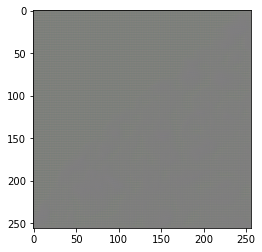

In [53]:
plt.imshow(v[0]*0.5+0.5)

In [52]:
sorted(glob(path_val+"/"+x+"/*"))

['/home/saab/Desktop/Processed_Data/Preprocessed_Data/brightfield/HE/Lung T STR 192-14_H&E_20220405_s48.jpg/000001.png',
 '/home/saab/Desktop/Processed_Data/Preprocessed_Data/brightfield/HE/Lung T STR 192-14_H&E_20220405_s48.jpg/000002.png',
 '/home/saab/Desktop/Processed_Data/Preprocessed_Data/brightfield/HE/Lung T STR 192-14_H&E_20220405_s48.jpg/000003.png',
 '/home/saab/Desktop/Processed_Data/Preprocessed_Data/brightfield/HE/Lung T STR 192-14_H&E_20220405_s48.jpg/000004.png',
 '/home/saab/Desktop/Processed_Data/Preprocessed_Data/brightfield/HE/Lung T STR 192-14_H&E_20220405_s48.jpg/000005.png',
 '/home/saab/Desktop/Processed_Data/Preprocessed_Data/brightfield/HE/Lung T STR 192-14_H&E_20220405_s48.jpg/000006.png',
 '/home/saab/Desktop/Processed_Data/Preprocessed_Data/brightfield/HE/Lung T STR 192-14_H&E_20220405_s48.jpg/000007.png',
 '/home/saab/Desktop/Processed_Data/Preprocessed_Data/brightfield/HE/Lung T STR 192-14_H&E_20220405_s48.jpg/000008.png',
 '/home/saab/Desktop/Processed_D

In [53]:
a.shape

NameError: name 'a' is not defined